# 2PN Binary System Orbit Visualization
This notebook computes and animates the motion of a binary system based on the second post-Newtonian (2PN) approximation and 2.5PN radiative energy terms from the paper "Third post-Newtonian dynamics of compact binaries: Equations of motion in the center-of-mass frame" by Luc Blanchet and Bala Iyer.
It requires some expansions of the 3PN equations up to 2.5PN order.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from IPython.display import HTML
from tqdm import tqdm


def set_axes_equal(ax):
    limits = np.array([
        ax.get_xlim3d(),
        ax.get_ylim3d(),
        ax.get_zlim3d(),
    ])
    centers = np.mean(limits, axis=1)
    radius = 0.5 * np.max(np.abs(limits[:,1] - limits[:,0]))
    for ctr, set_lim in zip(centers, [ax.set_xlim3d, ax.set_ylim3d, ax.set_zlim3d]):
        set_lim([ctr - radius, ctr + radius])

def create_sphere(center, radius=1.0, resolution=10):
    u = np.linspace(0, 2 * np.pi, resolution)
    v = np.linspace(0, np.pi, resolution)
    x = radius * np.outer(np.cos(u), np.sin(v)) + center[0]
    y = radius * np.outer(np.sin(u), np.sin(v)) + center[1]
    z = radius * np.outer(np.ones(np.size(u)), np.cos(v)) + center[2]
    return x, y, z

def compute_inspiral_trajectory_with_time(E_init, J_init, nu, M=1.0, r_init=None, max_steps=100000, dtau=0.1):
    print("Starting compute_inspiral_trajectory_with_time")

    def energy_2PN(r):
        x = M / r
        return -0.5 * M * nu * x * (1 + (-3/4 - (1/12)*nu)*x + (-27/8 + (19/8)*nu - (1/24)*nu**2)*x**2)

    def omega_2PN(r):
        x = M / r
        return (M / r**3)**0.5 * (1 + ( -3/2 + nu/2 )*x + (15/8 + ( -15/4 )*nu + (1/8)*nu**2)*x**2)

    def flux_2PN(r):
        x = M / r
        return -(32/5) * nu**2 * x**5 * (1 + (-1247/336 - 35/12*nu)*x + 4*np.pi*x**1.5 + (-44711/9072 + 9271/504*nu + 65/18*nu**2)*x**2)

    if r_init is None:
        r_init = - M**2 * nu / (2 * E_init)
    print(f"Initial r_init: {r_init}")

    sqrt1 = 0.5 + np.sqrt(0.25 - nu/4)
    sqrt2 = 0.5 - np.sqrt(0.25 - nu/4)
    m1 = sqrt1 * M
    m2 = sqrt2 * M
    print(f"Masses: m1 = {m1}, m2 = {m2}")

    t_list, x1_list, y1_list, z1_list = [], [], [], []
    x2_list, y2_list, z2_list = [], [], []

    r = r_init
    phi = 0.0
    E = energy_2PN(r)

    while r > 0.5 and len(t_list) < max_steps:
        t = len(t_list) * dtau
        t_list.append(t)

        x_rel = r * np.cos(phi)
        y_rel = r * np.sin(phi)

        x1_list.append(-m2/M * x_rel)
        y1_list.append(-m2/M * y_rel)
        z1_list.append(0.0)

        x2_list.append(m1/M * x_rel)
        y2_list.append(m1/M * y_rel)
        z2_list.append(0.0)

        Omega = omega_2PN(r)
        phi += Omega * dtau

        dE_dt = flux_2PN(r)
        E += dE_dt * dtau

        for _ in range(5):
            f = energy_2PN(r) - E
            df_dr = (energy_2PN(r * 1.0001) - energy_2PN(r * 0.9999)) / (0.0002 * r)
            r -= f / df_dr

    print("Finished compute_inspiral_trajectory_with_time")

    t_arr = np.array(t_list)
    t_arr = t_arr - np.max(t_arr)
    x1_arr = np.array(x1_list)
    y1_arr = np.array(y1_list)
    z1_arr = np.array(z1_list)
    x2_arr = np.array(x2_list)
    y2_arr = np.array(y2_list)
    z2_arr = np.array(z2_list)

    phi_arr = np.unwrap(np.arctan2(y1_arr - y2_arr, x1_arr - x2_arr))
    r_arr = np.sqrt((x1_arr - x2_arr)**2 + (y1_arr - y2_arr)**2 + (z1_arr - z2_arr)**2)

    h_plus = (1/r_arr) * np.cos(2*phi_arr)
    h_cross = (1/r_arr) * np.sin(2*phi_arr)

    return r_init, t_arr, x1_arr, y1_arr, z1_arr, x2_arr, y2_arr, z2_arr, h_plus, h_cross

def plot_gravitational_waveform(t_arr, h_plus, h_cross):

    fig_wave, ax_wave = plt.subplots(figsize=(10, 6))
    ax_wave.plot(t_arr, h_plus, label=r'$h_+$')
    ax_wave.plot(t_arr, h_cross, label=r'$h_\times$')
    ax_wave.set_xlabel('Time [M]')
    ax_wave.set_ylabel('Strain')
    ax_wave.set_title('Gravitational Waveform')
    ax_wave.legend()
    ax_wave.grid(True)
    fig_wave.savefig("gravitational_waveform.png")
    print("Gravitational waveform plot saved as 'gravitational_waveform.png'")


def animate_inspiral_3d(t_arr, x1_arr, y1_arr, z1_arr, x2_arr, y2_arr, z2_arr, interval=20, trail_length=9000):

    fig = plt.figure(figsize=(10, 8))
    ax3d = fig.add_subplot(111, projection='3d')
    lim = 20
    extra_frames = 90
    frame_skip = 25  # Reduced frame skip for smoother merger
    frames = list(range(0, len(t_arr), frame_skip)) + [len(t_arr)-1]*extra_frames

    sphere_res = 30
    u = np.linspace(0, 2 * np.pi, sphere_res)
    v = np.linspace(0, np.pi, sphere_res)
    base_x = np.outer(np.cos(u), np.sin(v))
    base_y = np.outer(np.sin(u), np.sin(v))
    base_z = np.outer(np.ones_like(u), np.cos(v))

    sphere1 = ax3d.plot_surface(base_x, base_y, base_z, color='black')
    sphere2 = ax3d.plot_surface(base_x, base_y, base_z, color='black')
    merged_sphere = ax3d.plot_surface(base_x, base_y, base_z, color='black', alpha=0)

    trail1, = ax3d.plot([], [], [], color='gray', alpha=0.7)
    trail2, = ax3d.plot([], [], [], color='gray', alpha=0.7)

    legend_text = ax3d.text2D(0.05, 0.95, '', transform=ax3d.transAxes)

    separation = np.sqrt((x1_arr - x2_arr)**2 + (y1_arr - y2_arr)**2 + (z1_arr - z2_arr)**2)
    merger_threshold = 0.5

    def set_sphere_surface(center, radius):
        x = radius * base_x + center[0]
        y = radius * base_y + center[1]
        z = radius * base_z + center[2]
        return x, y, z

    def init():
        ax3d.set_xlim3d([-lim, lim])
        ax3d.set_ylim3d([-lim, lim])
        ax3d.set_zlim3d([-lim, lim])
        ax3d.set_xlabel('x [M]')
        ax3d.set_ylabel('y [M]')
        ax3d.set_zlabel('z [M]')
        return []

    def update(frame_idx):
        nonlocal sphere1, sphere2, merged_sphere

        frame = frames[frame_idx]
        start = max(0, frame - trail_length)

        for surf in [sphere1, sphere2, merged_sphere]:
            if surf in ax3d.collections:
                surf.remove()

        is_merging = t_arr[frame] >= 0

        if not is_merging:
            x1, y1, z1 = set_sphere_surface([x1_arr[frame], y1_arr[frame], z1_arr[frame]], 1.5)
            x2, y2, z2 = set_sphere_surface([x2_arr[frame], y2_arr[frame], z2_arr[frame]], 1.5)
            sphere1 = ax3d.plot_surface(x1, y1, z1, color='black')
            sphere2 = ax3d.plot_surface(x2, y2, z2, color='black')
            merged_sphere = ax3d.plot_surface(base_x, base_y, base_z, color='black', alpha=0)
        else:
            merged_center = [(x1_arr[frame] + x2_arr[frame])/2, (y1_arr[frame] + y2_arr[frame])/2, (z1_arr[frame] + z2_arr[frame])/2]
            x_m, y_m, z_m = set_sphere_surface(merged_center, 2.0)
            merged_sphere = ax3d.plot_surface(x_m, y_m, z_m, color='black')
            sphere1 = merged_sphere
            sphere2 = merged_sphere

        trail1.set_data(x1_arr[start:frame], y1_arr[start:frame])
        trail1.set_3d_properties(z1_arr[start:frame])
        trail2.set_data(x2_arr[start:frame], y2_arr[start:frame])
        trail2.set_3d_properties(z2_arr[start:frame])

        if frame > 0:
            v1 = np.linalg.norm([x1_arr[frame]-x1_arr[frame-1], y1_arr[frame]-y1_arr[frame-1], z1_arr[frame]-z1_arr[frame-1]]) / (t_arr[frame]-t_arr[frame-1])
            v2 = np.linalg.norm([x2_arr[frame]-x2_arr[frame-1], y2_arr[frame]-y2_arr[frame-1], z2_arr[frame]-z2_arr[frame-1]]) / (t_arr[frame]-t_arr[frame-1])
            v_percent = min(99.0, 100 * max(v1, v2))
        else:
            v_percent = 0.0

        legend_text.set_text(f"Time: {t_arr[frame]:.1f} M\nVelocity: {v_percent:.2f}% c")

        return []

    ani = FuncAnimation(fig, update, frames=len(frames), init_func=init, interval=interval, blit=False)

    print("Saving 3D animation...")
    with tqdm(total=len(frames)) as pbar:
        class TQDMWriter(FFMpegWriter):
            def grab_frame(self, **savefig_kwargs):
                super().grab_frame(**savefig_kwargs)
                pbar.update(1)

        writer = TQDMWriter(fps=10, metadata=dict(artist='Me'), bitrate=1800)
        ani.save("inspiral_3d_animation.mp4", writer=writer, dpi=100)

    print("3D Animation saved as 'inspiral_3d_animation.mp4'")

    return ani



In [4]:
def check_inspiral_parameters(E_init, J_init, nu, M=1.0, orbit_threshold=200, time_threshold=100000):
    """
    Check if the binary parameters will cause a very long inspiral.

    Parameters:
    - E_init: Initial energy (must be negative)
    - J_init: Initial angular momentum
    - nu: Symmetric mass ratio (between 0 and 0.25)
    - M: Total mass (default 1.0)
    - orbit_threshold: max estimated orbits before warning
    - time_threshold: max estimated time [M] before warning

    Returns:
    - None, just prints a warning if necessary
    """

    if not (0 < nu <= 0.25):
        print("⚠️ Warning: Symmetric mass ratio nu must be in (0, 0.25].")
        return

    if E_init >= 0:
        print("⚠️ Warning: Energy must be negative for a bound system.")
        return

    # Estimate initial separation
    r_init = - M**2 * nu / (2 * E_init)
    
    # Orbital frequency and period
    Omega = np.sqrt(M / r_init**3)
    T_orb = 2 * np.pi / Omega  # orbital period
    
    # Rough inspiral estimate
    # Number of orbits scales roughly as r^(5/2)
    n_orbits_estimate = r_init**(2.5)
    t_inspiral_estimate = n_orbits_estimate * T_orb  # total inspiral time

    print(f"Estimated starting separation: r_init = {r_init:.2f} M")
    print(f"Estimated orbital period: T_orb = {T_orb:.2f} M")
    print(f"Estimated total inspiral time: {t_inspiral_estimate:.1f} M")
    print(f"Estimated number of orbits: {n_orbits_estimate:.1f}")

    if n_orbits_estimate > orbit_threshold or t_inspiral_estimate > time_threshold:
        print("⚠️ Warning: The inspiral will take a very long time!")
        print(f"Consider lowering J_init or making E_init more negative.")


Estimated starting separation: r_init = 12.50 M
Estimated orbital period: T_orb = 277.68 M
Estimated total inspiral time: 153398.1 M
Estimated number of orbits: 552.4
⚠️ Warning: The inspiral will take a very long time!
Consider lowering J_init or making E_init more negative.
Starting compute_inspiral_trajectory_with_time
Initial r_init: 12.5
Masses: m1 = 0.9330127018922193, m2 = 0.0669872981077807
Finished compute_inspiral_trajectory_with_time
Saving 3D animation...


100%|████████████████████████████████████████████████████████████████████████████████| 676/676 [06:45<00:00,  1.67it/s]


3D Animation saved as 'inspiral_3d_animation.mp4'
Gravitational waveform plot saved as 'gravitational_waveform.png'


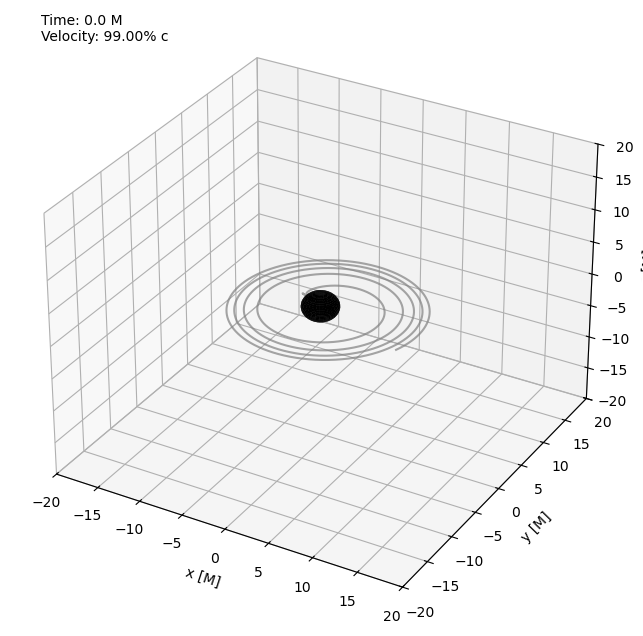

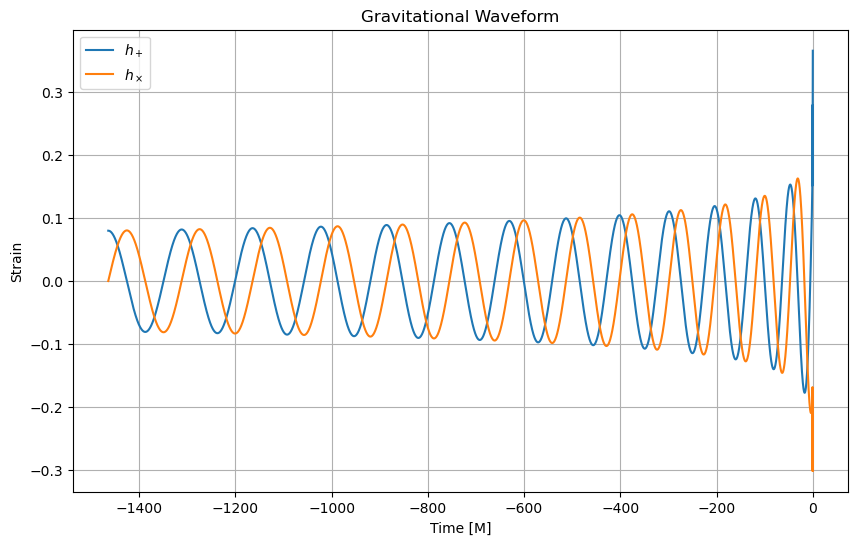

In [6]:
# Set initial binary parameters
E = -0.01  # Initial energy, must be negative for a bound system (example value, units of M)
J = 3.5     # Initial angular momentum (example value, units of M)
nu = 0.25   # Symmetric mass ratio, must be in the interval (0,0.25] (maximum for equal masses)

# Checks whether the set of passed values is 
# physical and estimates the total length of
# the animation
check_inspiral_parameters(E, J, nu)

# Calculate the inspiral and waveforms
r_init, t_arr, x1_arr, y1_arr, z1_arr, x2_arr, y2_arr, z2_arr, h_plus, h_cross = compute_inspiral_trajectory_with_time(E, J, nu)

# Save 3D animation
animate_inspiral_3d(t_arr, x1_arr, y1_arr, z1_arr, x2_arr, y2_arr, z2_arr)

# Create the waveform plot
plot_gravitational_waveform(t_arr, h_plus, h_cross)

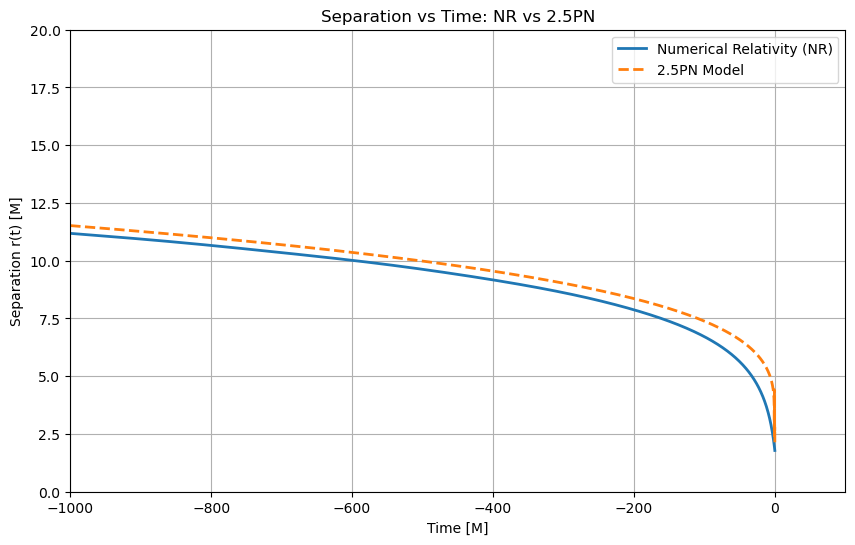

In [12]:
import sxs

sxs_bbh_0305 = sxs.load("SXS:BBH:0305")
horizons = sxs_bbh_0305.horizons

# Extract times
t_NR = horizons.A.time
max_t_NR = t_NR[-1]
t_NR_shifted = t_NR - max_t_NR

# 2PN time array
t_2PN = t_arr  # already available from previous code

# Extract coordinate centers
coords_A = horizons.A.coord_center_inertial
coords_B = horizons.B.coord_center_inertial

# Compute separation
r_NR = np.linalg.norm(coords_A - coords_B, axis=1)
r_2PN = np.sqrt((x1_arr - x2_arr)**2 + (y1_arr - y2_arr)**2 + (z1_arr - z2_arr)**2)

# Truncate NR to match 2PN 
len_NR = len(t_NR_shifted)
len_2PN = len(t_2PN)

t_NR_shifted_trunc = t_NR_shifted[-len_2PN:]
r_NR_trunc = r_NR[-len_2PN:]

# Plot both on same figure 
plt.figure(figsize=(10,6))
plt.grid(True)

plt.plot(t_NR_shifted_trunc, r_NR_trunc, label="Numerical Relativity (NR)", lw=2)
plt.plot(t_2PN, r_2PN, label="2.5PN Model", lw=2, linestyle='--')

plt.xlabel("Time [M]")
plt.ylabel("Separation r(t) [M]")
plt.title("Separation vs Time: NR vs 2.5PN")
plt.legend()
plt.xlim([-1000, 100])
plt.ylim([0, 20])
plt.show()

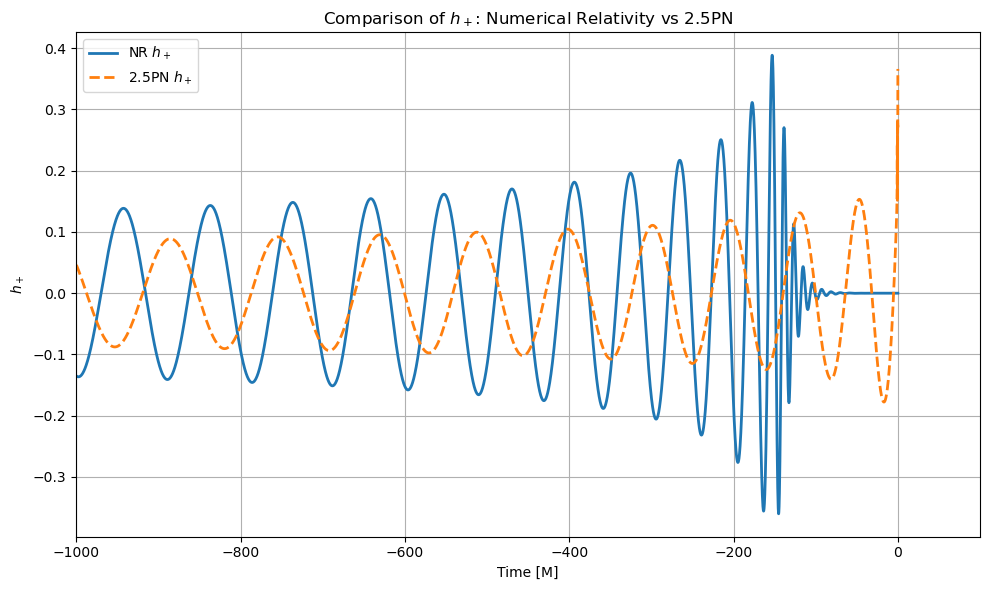

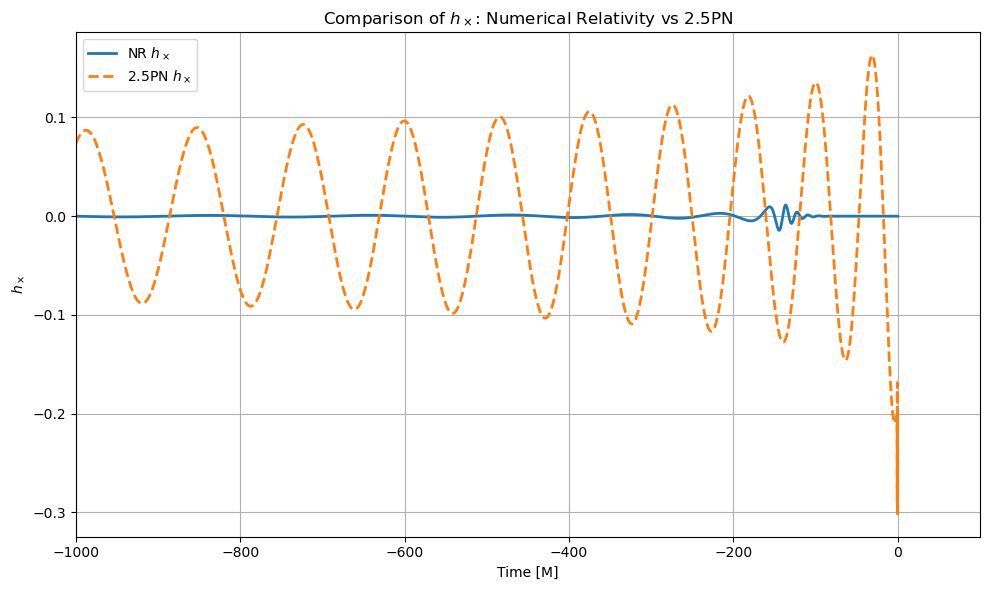

In [22]:
# --- 1. Load SXS data ---
sxs_bbh_0305 = sxs.load("SXS:BBH:0305")
waveform = sxs_bbh_0305.h

# Extract h_+ and h_x from SXS
h_NR_plus = waveform.data[:, 0]  # plus polarization
h_NR_cross = waveform.data[:, 1]  # cross polarization
t_NR = waveform.t

# 2PN data arrays
# already have: t_arr, h_plus, h_cross
# t_arr: time array for 2PN model
# h_plus: 2PN h_plus
# h_cross: 2PN h_cross

# 3. Time shifting
# Shift SXS time so that it starts from negative max and ends at zero
max_t_NR = t_NR[-1]
t_NR_shifted = t_NR - max_t_NR

# 4. Truncate NR arrays to match 2PN arrays
min_len = min(len(t_NR_shifted), len(t_arr))

# Truncate the NR arrays
t_NR_shifted = t_NR_shifted[-min_len:]
h_NR_plus = h_NR_plus[-min_len:]
h_NR_cross = h_NR_cross[-min_len:]

# Truncate the 2PN arrays
t_2PN = t_arr[-min_len:]
h_plus_2PN = h_plus[-min_len:]
h_cross_2PN = h_cross[-min_len:]

# 5. Plotting

# Plot h_plus comparison
plt.figure(figsize=(10, 6))
plt.plot(t_NR_shifted, h_NR_plus, label='NR $h_+$', linewidth=2)
plt.plot(t_2PN, h_plus_2PN, '--', label='2.5PN $h_+$', linewidth=2)
plt.xlabel('Time [M]')
plt.ylabel('$h_+$')
plt.title('Comparison of $h_+$: Numerical Relativity vs 2.5PN')
plt.legend()
plt.grid(True)
plt.xlim([-1000, 100])
plt.tight_layout()
plt.savefig("h_plus_NR_vs_2PN.png", dpi=600, transparent=True)
plt.show()

# Plot h_cross comparison
plt.figure(figsize=(10, 6))
plt.plot(t_NR_shifted, h_NR_cross, label='NR $h_\\times$', linewidth=2)
plt.plot(t_2PN, h_cross_2PN, '--', label='2.5PN $h_\\times$', linewidth=2)
plt.xlabel('Time [M]')
plt.ylabel('$h_\\times$')
plt.title('Comparison of $h_\\times$: Numerical Relativity vs 2.5PN')
plt.legend()
plt.grid(True)
plt.xlim([-1000, 100])
plt.tight_layout()
plt.savefig("h_cross_NR_vs_2PN.png", dpi=600, transparent=True)
plt.show()
